# 机器学习纳米学位
## 项目 7: 猫狗大战 Dog vs. Cat

## 导入需要的库

In [1]:
import numpy as np
import pandas as pd
import os, cv2, zipfile, shutil, h5py

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from tqdm import tqdm
from os.path import isfile, isdir
from sklearn.utils import shuffle

In [2]:
# Set random seed for Keras
np.random.seed(42)
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.applications import *

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


## 解压
解压前先从kaggle下载train.zip（训练集）和test.zip（测试集）到当前目录

In [3]:
def unzip_file(f_path):
    fzip = zipfile.ZipFile(f_path)
    fzip.extractall()

train = './train.zip'
train_folder = './train'
test = './test.zip'
test_folder = './test'

if not isdir(train_folder):
    unzip_file(train)
if not isdir(test_folder):
    unzip_file(test)

## 探索数据集
获取每张图片的分辨率以及通道数

In [4]:
train_info = []
for img in tqdm(os.listdir(train_folder)):
    info = cv2.imread(os.path.join(train_folder, img))
    train_info.append((info.shape, img))

100%|██████████| 25000/25000 [00:56<00:00, 442.96it/s]


In [5]:
train_info[0]

((335, 499, 3), 'dog.523.jpg')

### 图片大小分布

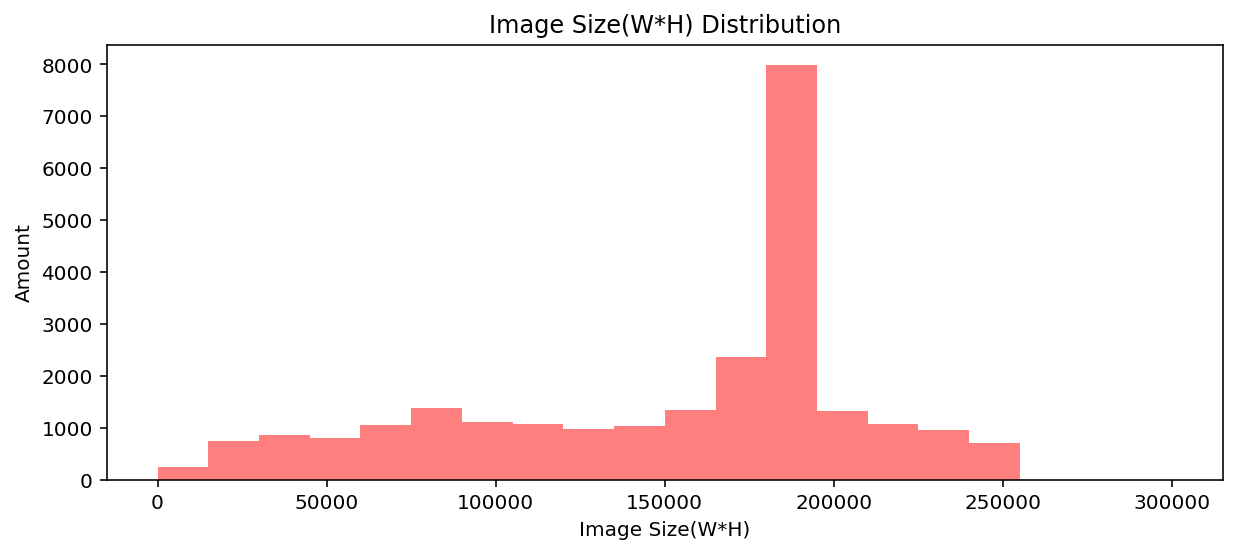

In [6]:
plt.figure(figsize=(10, 4))
img_size = [info[0][0]*info[0][1] for info in train_info]
plt.title("Image Size(W*H) Distribution")
plt.xlabel('Image Size(W*H)')
plt.ylabel('Amount')
plt.hist(img_size, bins = 20, alpha = 0.5, range = (0, 300000), color = 'red', label = 'image_size')
plt.show()

### 显示图片

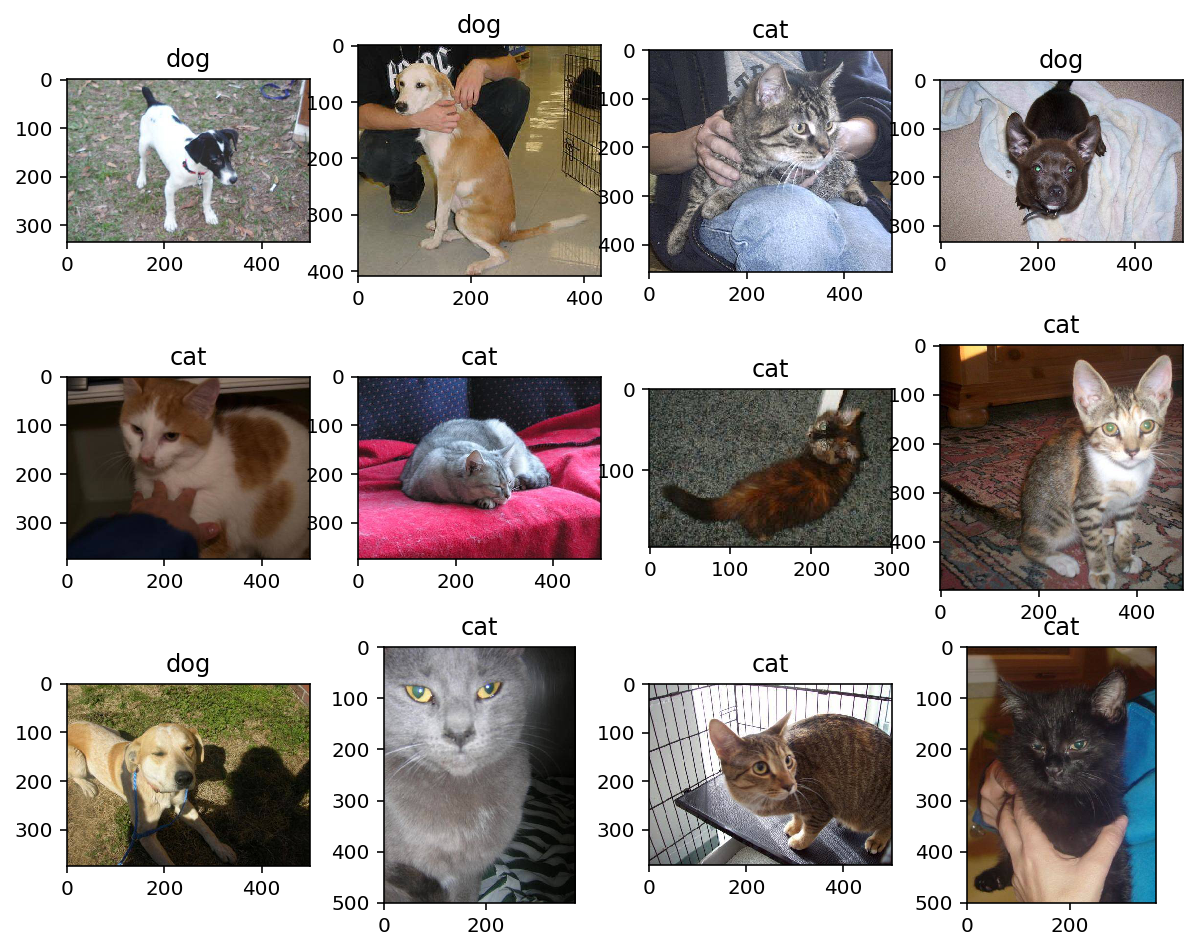

In [7]:
plt.figure(figsize=(10, 8))
for i, file in enumerate(os.listdir(train_folder)[:12]):
    img = plt.imread(os.path.join(train_folder, file))
    plt.subplot(3, 4, i+1)
    plt.title(file.split('.')[0])
    plt.axis('on')
    plt.imshow(img)

plt.show()

## 数据预处理

### 为Keras建立分类目录

为模型训练创建训练集、验证集和测试集目录

In [4]:
TRAIN_GEN = './train_gen'
TRAIN_GEN_DOG = './train_gen/dog'
TRAIN_GEN_CAT = './train_gen/cat'
VAL_GEN = './val_gen'
VAL_GEN_DOG = './val_gen/dog'
VAL_GEN_CAT = './val_gen/cat'

TEST_GEN = './test_gen'
TEST_GEN_MIXED = './test_gen/mixed'

train_cat = [file for file in os.listdir(train_folder) if 'cat' in file][:]
train_dog = [file for file in os.listdir(train_folder) if 'dog' in file][:]

val_num = int(len(train_dog) * .2)
val_dog = train_dog[-val_num:]
train_dog = train_dog[:-val_num]

val_cat = train_cat[-val_num:]
train_cat = train_cat[:-val_num]

print('There are {} train dogs and {} validation dogs'.format(len(train_dog), len(val_dog)))

There are 10000 train dogs and 2500 validation dogs


In [5]:
if not isdir(TRAIN_GEN):
    os.mkdir(TRAIN_GEN)
    os.mkdir(TRAIN_GEN_DOG)
    os.mkdir(TRAIN_GEN_CAT)
    for file in train_dog:
        os.symlink('../../train/'+file, TRAIN_GEN_DOG+r'/'+file)
    for file in train_cat:
        os.symlink('../../train/'+file, TRAIN_GEN_CAT+r'/'+file)

if not isdir(VAL_GEN):
    os.mkdir(VAL_GEN)
    os.mkdir(VAL_GEN_DOG)
    os.mkdir(VAL_GEN_CAT)
    for file in val_dog:
        os.symlink('../../train/'+file, VAL_GEN_DOG+r'/'+file)
    for file in val_cat:
        os.symlink('../../train/'+file, VAL_GEN_CAT+r'/'+file)

if not isdir(TEST_GEN):
    os.mkdir(TEST_GEN)
    os.mkdir(TEST_GEN_MIXED)
    for file in os.listdir(test_folder)[:]:
        os.symlink('../../test/'+file, TEST_GEN_MIXED+r'/'+file)

为特征提取创建训练集目录

In [6]:
TRAIN_GEN_EX = './train_gen_ex'
TRAIN_GEN_EX_DOG = './train_gen_ex/dog'
TRAIN_GEN_EX_CAT = './train_gen_ex/cat'

TEST_GEN = './test_gen'
TEST_GEN_MIXED = './test_gen/mixed'

train_cat = [file for file in os.listdir(train_folder) if 'cat' in file][:]
train_dog = [file for file in os.listdir(train_folder) if 'dog' in file][:]

print('There are {} train dogs'.format(len(train_dog)))

There are 12500 train dogs


In [7]:
if not isdir(TRAIN_GEN_EX):
    os.mkdir(TRAIN_GEN_EX)
    os.mkdir(TRAIN_GEN_EX_DOG)
    os.mkdir(TRAIN_GEN_EX_CAT)
    for file in train_dog:
        os.symlink('../../train/'+file, TRAIN_GEN_EX_DOG+r'/'+file)
    for file in train_cat:
        os.symlink('../../train/'+file, TRAIN_GEN_EX_CAT+r'/'+file)

## 导入迁移学习类
类方法包括创建图片数据生成器、构建和设置预训练模型、训练、预测

In [9]:
from transfer_learning import *

## 单模型fine tune和特征提取

----
## ResNet50

### 构建模型

In [115]:
tl_resnet50 = TransferLearning_CNN(
                    train_dir=TRAIN_GEN,
                    val_dir=VAL_GEN,
                    test_dir=TEST_GEN,
                    model_name='resnet50',
                    fine_tune_layer=20,
                    epochs=8,
                    patience=5,
                    batch_size=128,
                    img_sz=(224,224))

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 1000 images belonging to 1 classes.


### 列出模型信息

In [14]:
tl_resnet50.model_summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

### 训练模型

In [116]:
result = tl_resnet50.model_fit()

Epoch 1/8
13/13 [==============================] - 38s 3s/step - loss: 0.1707 - acc: 0.9296 - val_loss: 0.2728 - val_acc: 0.9775

Epoch 00001: saving model to resnet50_01_0.2728.hdf5
Epoch 2/8
13/13 [==============================] - 20s 2s/step - loss: 0.0494 - acc: 0.9802 - val_loss: 0.1599 - val_acc: 0.9825

Epoch 00002: saving model to resnet50_02_0.1599.hdf5
Epoch 3/8
13/13 [==============================] - 25s 2s/step - loss: 0.0223 - acc: 0.9946 - val_loss: 0.2629 - val_acc: 0.9675

Epoch 00003: saving model to resnet50_03_0.2629.hdf5
Epoch 4/8
13/13 [==============================] - 26s 2s/step - loss: 0.0120 - acc: 0.9958 - val_loss: 0.1533 - val_acc: 0.9800

Epoch 00004: saving model to resnet50_04_0.1533.hdf5
Epoch 5/8
13/13 [==============================] - 26s 2s/step - loss: 0.0106 - acc: 0.9982 - val_loss: 0.1934 - val_acc: 0.9650

Epoch 00005: saving model to resnet50_05_0.1934.hdf5
Epoch 6/8
13/13 [==============================] - 25s 2s/step - loss: 0.0048 - acc: 

### 可视化训练过程

Saving trainning history to file: train_log_resnet50.npz
Restoring trainning history from file: train_log_resnet50.npz


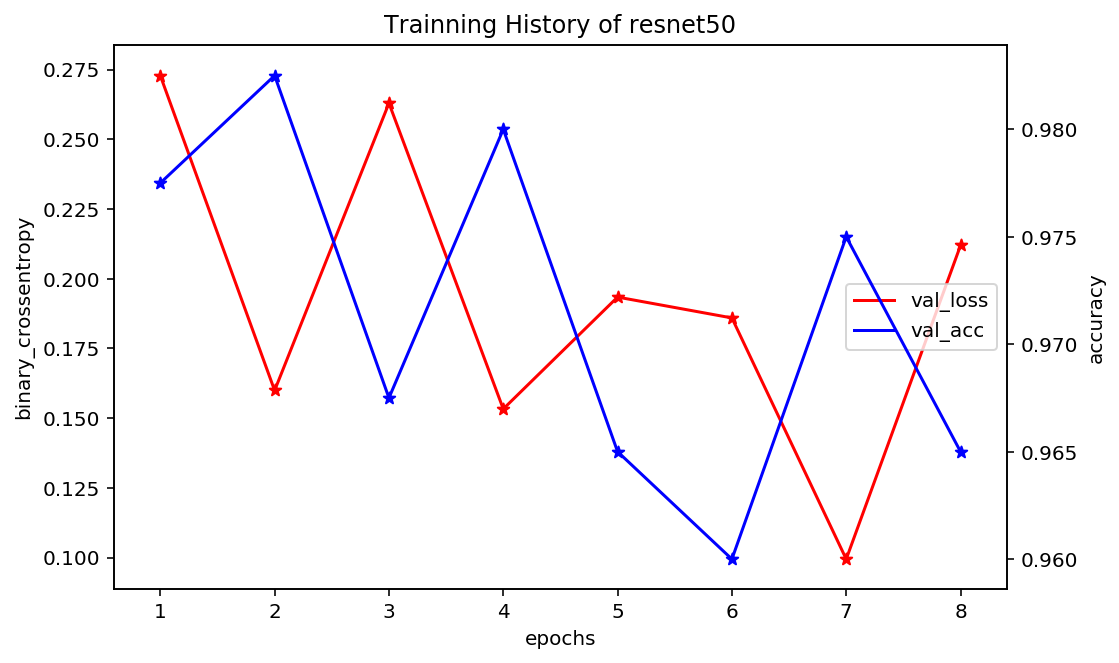

In [117]:
tl_resnet50.save_training_log()
tl_resnet50.load_training_log()
tl_resnet50.visualize_trainning()

### 预测并输出结果到csv文件

加载最优模型（选择val_loss最小）

In [118]:
best_model = tl_resnet50.find_best_model()
tl_resnet50.load_model(best_model)

The best model is: resnet50_07_0.0994.hdf5


将预测结果输出至csv文件

In [71]:
tl_resnet50.model_pred()
tl_resnet50.save_test_csv()

8/8 [==============================] - 15s 2s/step
Saving test result on: pred_resnet50.csv


### 特征提取

分别针对原始图像和使用数据增强变换后的图像

In [119]:
tl_resnet50.hl_feature_extractor(TRAIN_GEN_EX, feature_enh=False)
tl_resnet50.hl_feature_extractor(TRAIN_GEN_EX, feature_enh=True)

The output of model:  Tensor("global_average_pooling2d_17_1/Mean:0", shape=(?, 2048), dtype=float32)
Non Data augmentation
Found 2000 images belonging to 2 classes.
Gen feature from train data ...
16/16 [==============================] - 28s 2s/step
Gen feature from test data ...
8/8 [==============================] - 10s 1s/step
Write feature to file: feature_resnet50.h5
The output of model:  Tensor("global_average_pooling2d_17_1/Mean:0", shape=(?, 2048), dtype=float32)
Data augmentation
Found 2000 images belonging to 2 classes.
Gen feature from train data ...
16/16 [==============================] - 31s 2s/step
Write feature to file: feature_enh_resnet50.h5


----
## Xception

### 构建模型

In [74]:
tl_xception = TransferLearning_CNN(
                    train_dir=TRAIN_GEN,
                    val_dir=VAL_GEN,
                    test_dir=TEST_GEN,
                    model_name='xception',
                    fine_tune_layer=32,
                    epochs=8,
                    patience=5,
                    batch_size=128,
                    img_sz=(299,299))

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 1000 images belonging to 1 classes.


### 列出模型信息

In [75]:
tl_xception.model_summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_13[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

### 训练模型

In [76]:
result = tl_xception.model_fit()

Epoch 1/8
13/13 [==============================] - 67s 5s/step - loss: 0.1383 - acc: 0.9393 - val_loss: 0.0296 - val_acc: 0.9950

Epoch 00001: saving model to xception_01_0.0296.hdf5
Epoch 2/8
13/13 [==============================] - 50s 4s/step - loss: 0.0210 - acc: 0.9934 - val_loss: 0.0429 - val_acc: 0.9900

Epoch 00002: saving model to xception_02_0.0429.hdf5
Epoch 3/8
13/13 [==============================] - 50s 4s/step - loss: 0.0096 - acc: 0.9964 - val_loss: 0.0381 - val_acc: 0.9900

Epoch 00003: saving model to xception_03_0.0381.hdf5
Epoch 4/8
13/13 [==============================] - 50s 4s/step - loss: 0.0072 - acc: 0.9970 - val_loss: 0.0441 - val_acc: 0.9825

Epoch 00004: saving model to xception_04_0.0441.hdf5
Epoch 5/8
13/13 [==============================] - 50s 4s/step - loss: 0.0076 - acc: 0.9976 - val_loss: 0.0428 - val_acc: 0.9925

Epoch 00005: saving model to xception_05_0.0428.hdf5
Epoch 00005: early stopping


### 可视化训练过程

Saving trainning history to file: train_log_xception.npz
Restoring trainning history from file: train_log_xception.npz


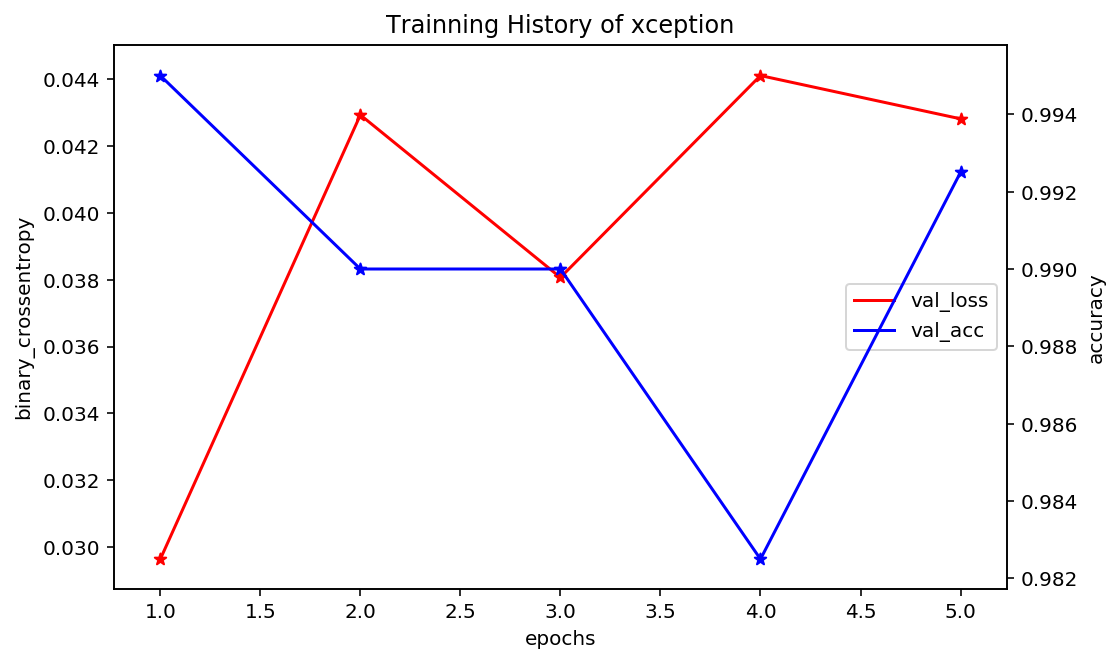

In [77]:
tl_xception.save_training_log()
tl_xception.load_training_log()
tl_xception.visualize_trainning()

### 预测并输出结果到csv文件

加载最优模型（val_loss最小）

In [79]:
best_model = tl_xception.find_best_model()
tl_xception.load_model(best_model)

The best model is: xception_01_0.0296.hdf5


将预测结果输出至csv文件

In [78]:
tl_xception.model_pred()
tl_xception.save_test_csv()

8/8 [==============================] - 27s 3s/step
Saving test result on: pred_xception.csv


### 特征提取

分别针对原始图像和使用数据增强变换后的图像

In [80]:
tl_xception.hl_feature_extractor(TRAIN_GEN_EX, feature_enh=False)
tl_xception.hl_feature_extractor(TRAIN_GEN_EX, feature_enh=True)

The output of model:  Tensor("global_average_pooling2d_13_1/Mean:0", shape=(?, 2048), dtype=float32)
Non Data augmentation
Found 2000 images belonging to 2 classes.
Gen feature from train data ...
16/16 [==============================] - 48s 3s/step
Gen feature from test data ...
8/8 [==============================] - 22s 3s/step
Write feature to file: feature_xception.h5
The output of model:  Tensor("global_average_pooling2d_13_1/Mean:0", shape=(?, 2048), dtype=float32)
Data augmentation
Found 2000 images belonging to 2 classes.
Gen feature from train data ...
16/16 [==============================] - 52s 3s/step
Write feature to file: feature_enh_xception.h5


----
## Inception_ResNet_V2

### 构建模型

In [83]:
tl_inception_restnet_v2 = TransferLearning_CNN(
                                train_dir=TRAIN_GEN,
                                val_dir=VAL_GEN,
                                test_dir=TEST_GEN,
                                model_name='inception_res_v2',
                                fine_tune_layer=80,
                                epochs=8,
                                patience=4,
                                batch_size=128,
                                img_sz=(299,299))

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 1000 images belonging to 1 classes.
219062272/219055592 [==============================] - 3s 0us/step


### 列出模型信息

In [84]:
tl_inception_restnet_v2.model_summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 149, 149, 32) 864         input_14[0][0]                   
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 149, 149, 32) 96          conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation_589 (Activation)     (None, 149, 149, 32) 0           batch_normalization_5[0][0]      
__________________________________________________________________________________________________
conv2d_6 (

__________________________________________________________________________________________________
block8_2_ac (Activation)        (None, 8, 8, 2080)   0           block8_2[0][0]                   
__________________________________________________________________________________________________
conv2d_177 (Conv2D)             (None, 8, 8, 192)    399360      block8_2_ac[0][0]                
__________________________________________________________________________________________________
batch_normalization_177 (BatchN (None, 8, 8, 192)    576         conv2d_177[0][0]                 
__________________________________________________________________________________________________
activation_761 (Activation)     (None, 8, 8, 192)    0           batch_normalization_177[0][0]    
__________________________________________________________________________________________________
conv2d_178 (Conv2D)             (None, 8, 8, 224)    129024      activation_761[0][0]             
__________

### 训练模型

In [85]:
result = tl_inception_restnet_v2.model_fit()

Epoch 1/8
13/13 [==============================] - 76s 6s/step - loss: 0.1983 - acc: 0.9266 - val_loss: 0.6242 - val_acc: 0.9100

Epoch 00001: saving model to inception_res_v2_01_0.6242.hdf5
Epoch 2/8
13/13 [==============================] - 52s 4s/step - loss: 0.0564 - acc: 0.9790 - val_loss: 2.2455 - val_acc: 0.6750

Epoch 00002: saving model to inception_res_v2_02_2.2455.hdf5
Epoch 3/8
13/13 [==============================] - 52s 4s/step - loss: 0.0240 - acc: 0.9904 - val_loss: 0.1097 - val_acc: 0.9775

Epoch 00003: saving model to inception_res_v2_03_0.1097.hdf5
Epoch 4/8
13/13 [==============================] - 52s 4s/step - loss: 0.0114 - acc: 0.9952 - val_loss: 0.1691 - val_acc: 0.9725

Epoch 00004: saving model to inception_res_v2_04_0.1691.hdf5
Epoch 5/8
13/13 [==============================] - 52s 4s/step - loss: 0.0033 - acc: 0.9988 - val_loss: 0.0268 - val_acc: 0.9900

Epoch 00005: saving model to inception_res_v2_05_0.0268.hdf5
Epoch 6/8
13/13 [============================

### 可视化训练过程

Saving trainning history to file: train_log_inception_res_v2.npz
Restoring trainning history from file: train_log_inception_res_v2.npz


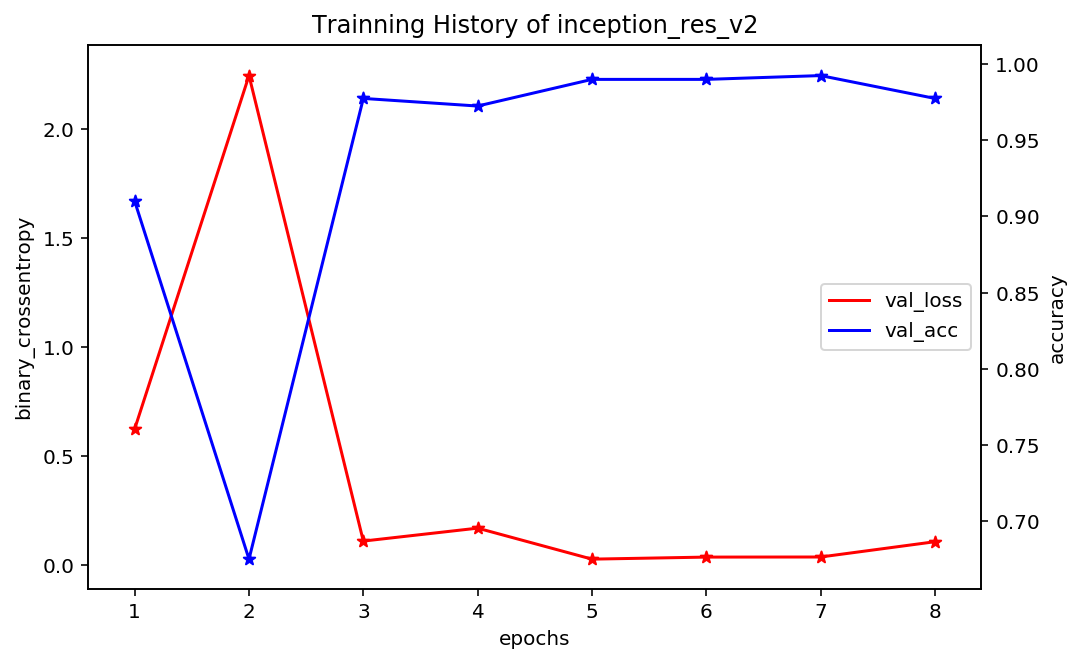

In [86]:
tl_inception_restnet_v2.save_training_log()
tl_inception_restnet_v2.load_training_log()
tl_inception_restnet_v2.visualize_trainning()

### 预测并输出结果到csv文件

加载最优模型（val_loss最小）

In [88]:
best_model = tl_inception_restnet_v2.find_best_model()
tl_inception_restnet_v2.load_model(best_model)

The best model is: inception_res_v2_05_0.0268.hdf5


将预测结果输出至csv文件

In [87]:
tl_inception_restnet_v2.model_pred()
tl_inception_restnet_v2.save_test_csv()

8/8 [==============================] - 35s 4s/step
Saving test result on: pred_inception_res_v2.csv


### 特征提取

分别针对原始图像和使用数据增强变换后的图像

In [ ]:
tl_inception_restnet_v2.hl_feature_extractor(TRAIN_GEN_EX, feature_enh=False)
tl_inception_restnet_v2.hl_feature_extractor(TRAIN_GEN_EX, feature_enh=True)

## 完善：多模型提取特征+组合

### 原始图像提取的特征
将各模型提取的特征拼接在一起

In [23]:
X_train = []
X_test = []
weight = [0.2, 0.2, 0.6]
#“feature_resnet50.h5”, "feature_xception.h5", feature_inception_v3.h5
for i, filename in enumerate(["feature_resnet50.h5", "feature_xception.h5", "feature_inception_res_v2.h5"]):
    with h5py.File(filename, 'r') as h:
        X_train.append(weight[i]*np.array(h['train']))
        X_test.append(weight[i]*np.array(h['test']))
        y_train = np.array(h['label'])

X_train_load = np.concatenate(X_train, axis=1)
y_train_load = y_train
X_test = np.concatenate(X_test, axis=1)

X_train = X_train_load
y_train = y_train_load

In [24]:
gen = ImageDataGenerator()

train_gen = gen.flow_from_directory(
    './train_gen_ex', 
    target_size=(224,224), 
    shuffle=False, 
    batch_size=128, 
    class_mode=None,
)
filenames = train_gen.filenames

Found 25000 images belonging to 2 classes.


### 数据增强后提取的特征
将各模型提取的特征拼接在一起

In [45]:
import h5py
import numpy as np
from sklearn.utils import shuffle

X_train_enh = []
weight = [1, 1, 1]

for i,filename in enumerate(["feature_enh_resnet50.h5", "feature_enh_xception.h5", "feature_enh_inception_res_v2.h5"]):
    with h5py.File(filename, 'r') as h:
        X_train_enh.append(weight[i]*np.array(h['train']))
        y_train_enh = np.array(h['label'])

X_train_enh = np.concatenate(X_train_enh, axis=1)

### 混洗数据

In [25]:
X_train, y_train, filenames = shuffle(X_train, y_train, filenames, random_state=42)

In [46]:
X_train_enh, y_train_enh = shuffle(X_train_enh, y_train_enh, random_state=42)

### 训练

In [26]:
np.random.seed(42)

def get_nn_clf():
    input_tensor = Input(X_train.shape[1:])

    x = input_tensor
    x = Dropout(0.6)(x)
    x = Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform',
              kernel_regularizer=None, 
              bias_regularizer=None, 
              activity_regularizer=None)(x)

    model = Model(input_tensor, x)

    sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    model.compile(optimizer=adam,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [20]:
epochs = 50
patience = 0
batch_size = 128

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

check_pt = ModelCheckpoint(
    'ensumble_{epoch:02d}_{val_loss:.4f}.hdf5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False, 
    period=1
)

early_stop = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.00005,
    patience=patience, 
    verbose=1, 
    mode='auto'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=3,
    verbose=1,
    epsilon=0.0001,
    mode='auto',
)

In [27]:
model = get_nn_clf()
result = model.fit(X_train, 
                   y_train, batch_size=batch_size, 
                   epochs=10, validation_split=0.2, shuffle=False, callbacks=[])

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 2s 81us/step - loss: 0.0238 - acc: 0.9946 - val_loss: 0.0073 - val_acc: 0.9978
Epoch 2/10
20000/20000 [==============================] - 1s 51us/step - loss: 0.0076 - acc: 0.9978 - val_loss: 0.0062 - val_acc: 0.9976
Epoch 3/10
20000/20000 [==============================] - 1s 51us/step - loss: 0.0070 - acc: 0.9977 - val_loss: 0.0058 - val_acc: 0.9978
Epoch 4/10
20000/20000 [==============================] - 1s 60us/step - loss: 0.0065 - acc: 0.9978 - val_loss: 0.0054 - val_acc: 0.9978
Epoch 5/10
20000/20000 [==============================] - 1s 52us/step - loss: 0.0062 - acc: 0.9979 - val_loss: 0.0052 - val_acc: 0.9978
Epoch 6/10
20000/20000 [==============================] - 1s 59us/step - loss: 0.0057 - acc: 0.9981 - val_loss: 0.0049 - val_acc: 0.9980
Epoch 7/10
20000/20000 [==============================] - 1s 60us/step - loss: 0.0055 - acc: 0.9981 - val_loss: 0.0047 - val_acc:

### 可视化训练结果

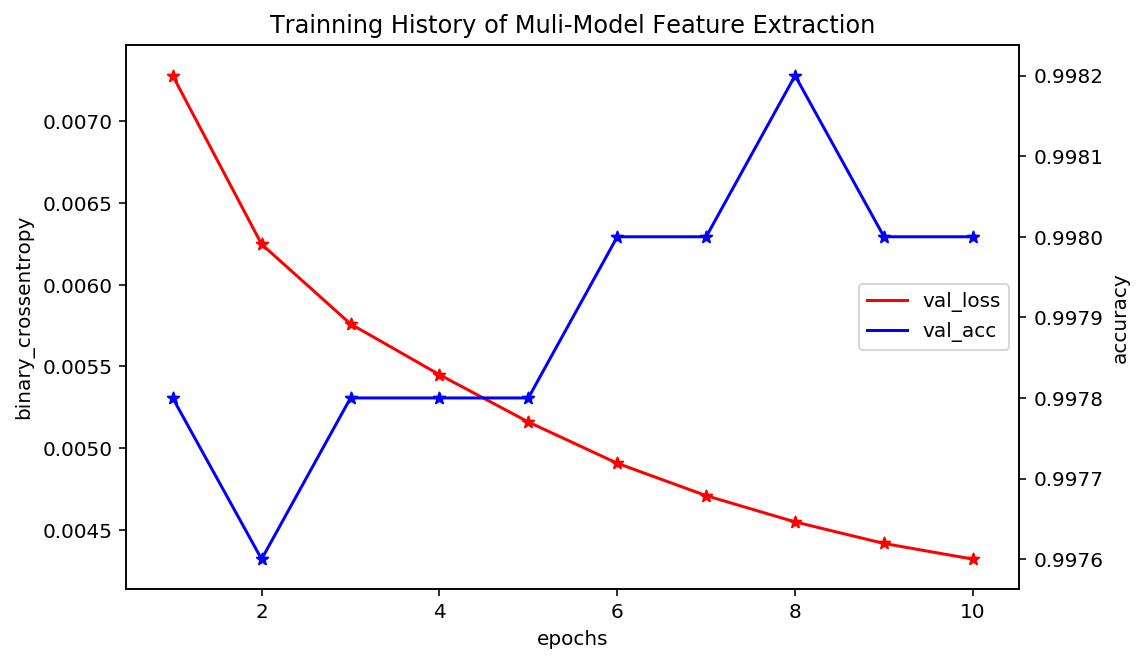

In [28]:
epoch = list(map(lambda x:x+1, result.epoch))
visualize_epochs(epoch, result.history, 'Trainning History of Muli-Model Feature Extraction')

### 预测

In [29]:
gen = ImageDataGenerator()

test_gen = gen.flow_from_directory(
    './test_gen', 
    target_size=(224,224), 
    shuffle=False, 
    batch_size=128, 
    class_mode=None,
)

Found 12500 images belonging to 1 classes.


In [30]:
y_pred = model.predict(X_test, verbose=1)
df = save_test_to_csv(y_pred, 'merge', test_gen)

12500/12500 [==============================] - 0s 33us/step
Saving test result on: pred_merge.csv


### 针对错判样本
将训练好的模型对所有训练数据进行预测，并与实际标签对比，取出预测结果与标签不符图片

In [28]:
train_pred = model.predict(X_train, verbose=1)

25000/25000 [==============================] - 1s 29us/step


In [29]:
pred = (train_pred >= 0.5)*1
pred = pred[:, 0]
error = [i for i,(p,y) in enumerate(zip(pred, y_train)) if p != y]
len(error)

44

In [31]:
outlier_2 = [(filenames[e].split('/')[1], y_train[e], train_pred[e]) for e in error 
                 if (y_train[e]==0 and train_pred[e]>=0.65) or (y_train[e]==1 and train_pred[e]<=0.35)]
for f,_,_ in [*outlier_2]:
    print('\''+f+'\',')
print('Total outlier is {}'.format(len(outlier_2)))

'cat.4688.jpg',
'cat.12272.jpg',
'dog.10179.jpg',
'dog.12142.jpg',
'dog.2542.jpg',
'cat.11399.jpg',
'cat.6699.jpg',
'cat.7920.jpg',
'cat.5241.jpg',
'cat.10266.jpg',
'dog.5767.jpg',
'cat.3658.jpg',
'dog.4334.jpg',
'dog.5529.jpg',
'dog.6921.jpg',
'cat.8456.jpg',
'dog.9150.jpg',
'dog.8507.jpg',
'cat.4085.jpg',
'cat.9250.jpg',
'dog.11731.jpg',
'dog.6405.jpg',
'cat.6906.jpg',
'cat.724.jpg',
Total outlier is 24


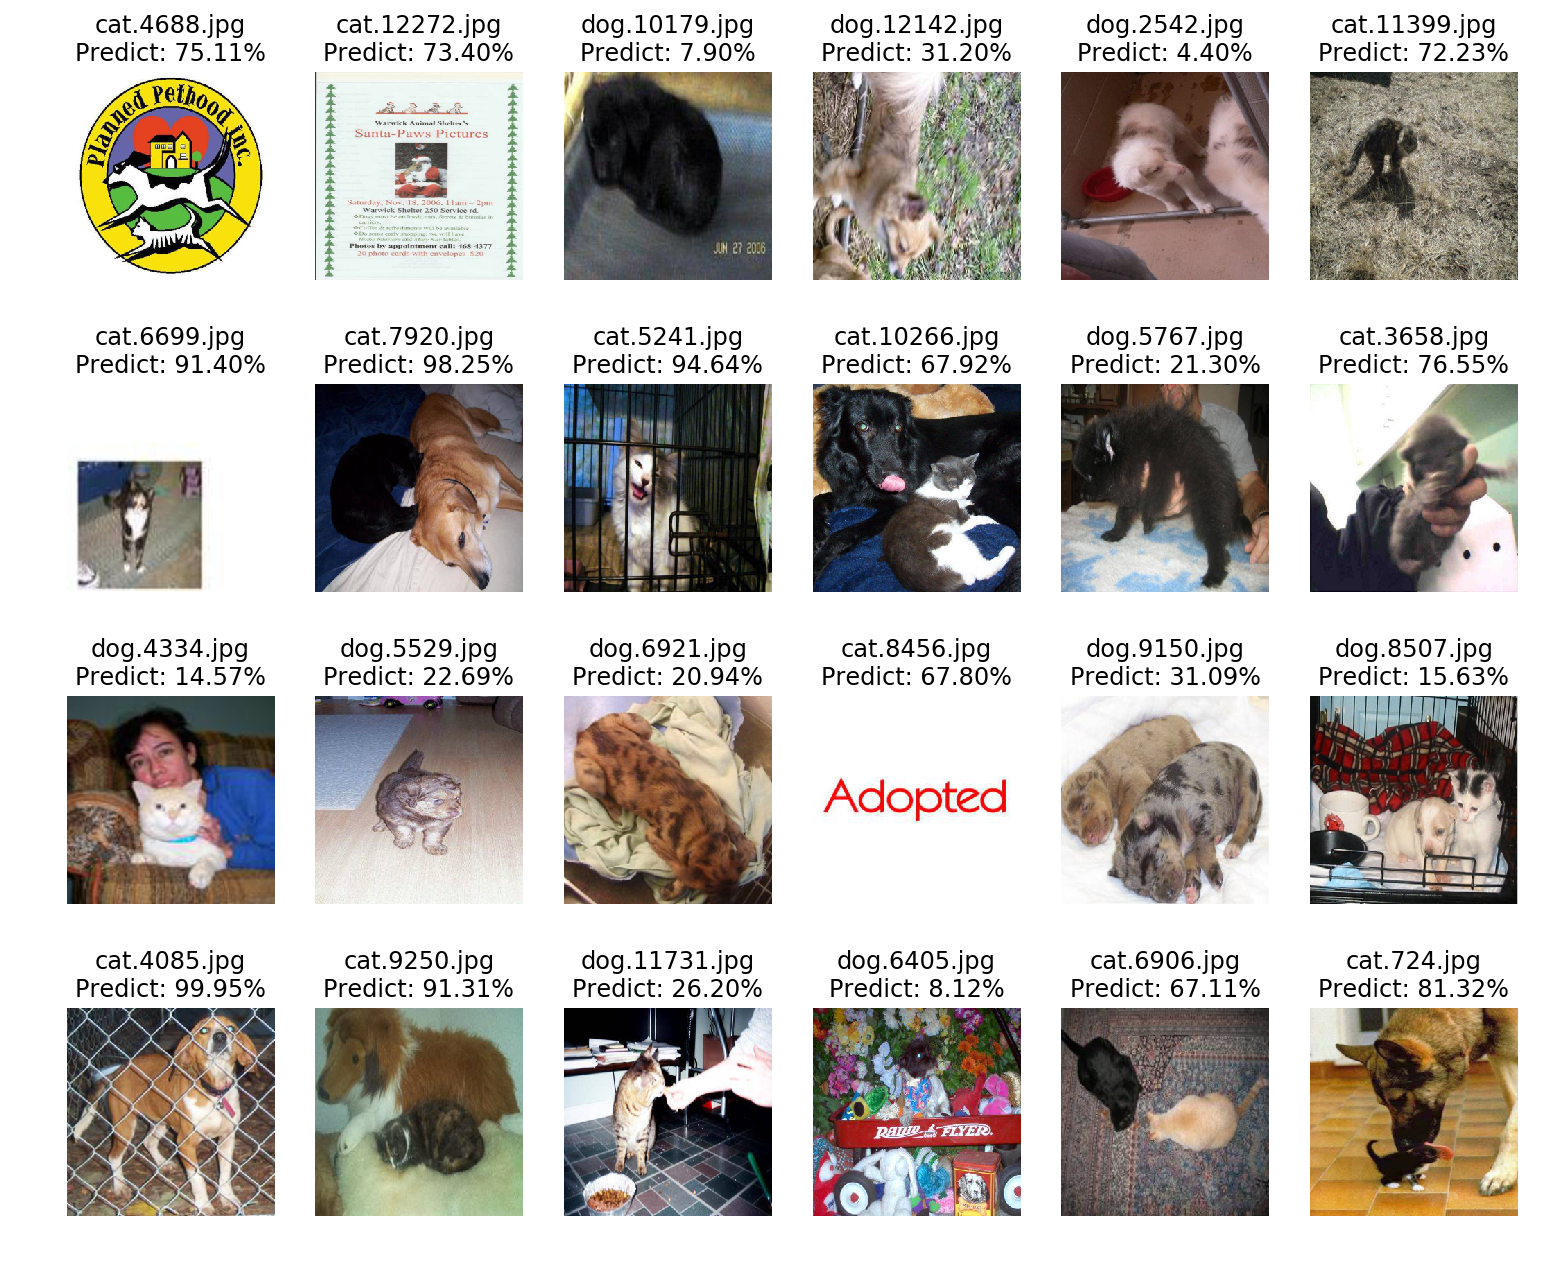

In [36]:
plt.figure(figsize=(13, 11))

for i, (f,_,p) in enumerate([*outlier_2][:36]):
    img = cv2.resize(plt.imread(os.path.join(train_folder, f)), (300, 300))
    plt.subplot(4, 6, i+1)
    plt.title(f + '\n' + 'Predict: {:.2f}%'.format(p[0]*100))
    plt.axis('off')
    plt.imshow(img)

plt.show()

### 去除异常样本

In [37]:
outlier = [
'cat.4688.jpg',
'cat.12272.jpg',
'dog.10179.jpg',
'dog.12142.jpg',
'dog.2542.jpg',
'cat.11399.jpg',
'cat.6699.jpg',
'cat.7920.jpg',
'cat.5241.jpg',
'cat.10266.jpg',
'dog.5767.jpg',
'cat.3658.jpg',
'dog.4334.jpg',
'dog.5529.jpg',
'dog.6921.jpg',
'cat.8456.jpg',
'dog.9150.jpg',
'dog.8507.jpg',
'cat.4085.jpg',
'cat.9250.jpg',
'dog.11731.jpg',
'dog.6405.jpg',
'cat.6906.jpg',
'cat.724.jpg',
]

In [38]:
outlier_n = [i for i,fn in enumerate(train_gen.filenames) if fn.split('/')[1] in outlier]
X_train = np.array([x for i,x in enumerate(X_train_load) if i not in outlier_n])
X_train.shape

(24976, 5632)

In [39]:
y_train = np.array([x for i,x in enumerate(y_train_load) if i not in outlier_n])
y_train.shape

(24976,)

In [40]:
filenames = [x for i,x in enumerate(train_gen.filenames) if i not in outlier_n]
len(filenames)

24976

### 重新混洗

In [41]:
X_train, y_train, filenames = shuffle(X_train, y_train, filenames, random_state=42)

### 重新训练

In [47]:
np.random.seed(42)

model = get_nn_clf()
result = model.fit(X_train, 
                   y_train, batch_size=batch_size, 
                   epochs=18, validation_split=0.2, shuffle=False, callbacks=[])

Train on 19980 samples, validate on 4996 samples
Epoch 1/18
19980/19980 [==============================] - 2s 94us/step - loss: 0.0210 - acc: 0.9959 - val_loss: 0.0069 - val_acc: 0.9982
Epoch 2/18
19980/19980 [==============================] - 1s 50us/step - loss: 0.0046 - acc: 0.9987 - val_loss: 0.0057 - val_acc: 0.9982
Epoch 3/18
19980/19980 [==============================] - 1s 50us/step - loss: 0.0038 - acc: 0.9985 - val_loss: 0.0052 - val_acc: 0.9982
Epoch 4/18
19980/19980 [==============================] - 1s 50us/step - loss: 0.0034 - acc: 0.9987 - val_loss: 0.0049 - val_acc: 0.9982
Epoch 5/18
19980/19980 [==============================] - 1s 51us/step - loss: 0.0030 - acc: 0.9987 - val_loss: 0.0047 - val_acc: 0.9982
Epoch 6/18
19980/19980 [==============================] - 1s 61us/step - loss: 0.0028 - acc: 0.9988 - val_loss: 0.0046 - val_acc: 0.9982
Epoch 7/18
19980/19980 [==============================] - 1s 61us/step - loss: 0.0027 - acc: 0.9988 - val_loss: 0.0044 - val_acc:

### 使用增强数据继续训练2个epoch

In [48]:
model.fit(X_train_enh, y_train_enh, batch_size=batch_size, epochs=2, validation_split=0.2, shuffle=True, callbacks=[])

Train on 20000 samples, validate on 5000 samples
Epoch 1/2
20000/20000 [==============================] - 1s 52us/step - loss: 0.0131 - acc: 0.9974 - val_loss: 0.0068 - val_acc: 0.9980
Epoch 2/2
20000/20000 [==============================] - 1s 51us/step - loss: 0.0077 - acc: 0.9984 - val_loss: 0.0067 - val_acc: 0.9976


## 预测 - 最终结果

In [49]:
y_pred = model.predict(X_test, verbose=1)
df = save_test_to_csv(y_pred, 'merge', test_gen)

12500/12500 [==============================] - 0s 37us/step
Saving test result on: pred_merge.csv


## 可视化测试结果

In [53]:
P = shuffle(df['label'], random_state=2018)
P = P[P < 0.8]
P = P[P > 0.2]

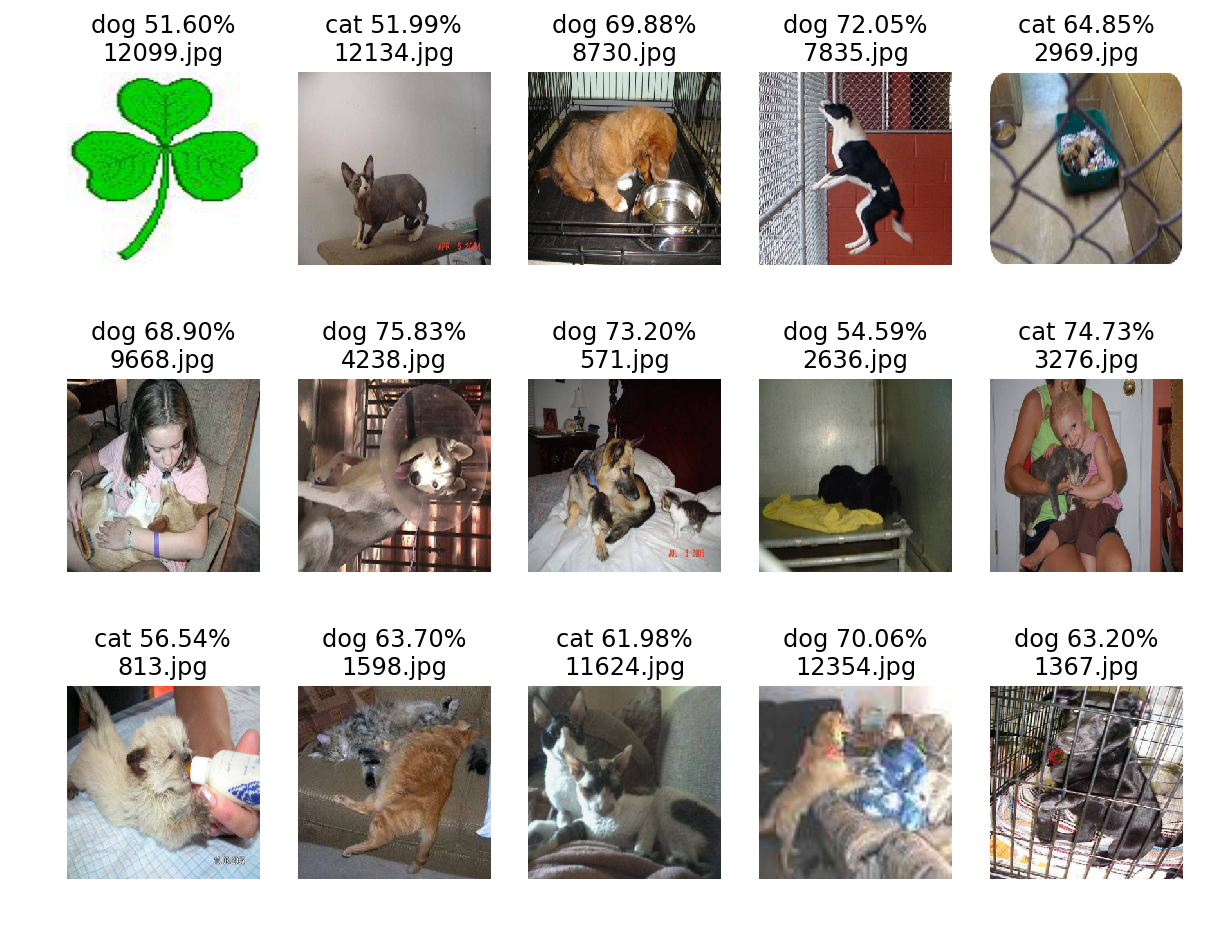

In [55]:
plt.figure(figsize=(10, 8))

i=0
for i, (p,index) in enumerate(zip(P[i:15+i], P.index[i:15+i])):
    img = cv2.resize(plt.imread(os.path.join(test_folder, str(index+1)+'.jpg')), (300, 300))
    plt.subplot(3, 5, i+1)
    label = 'dog' if p>=0.5 else 'cat'
    p = 1-p if p<0.5 else p
    plt.title(label + ' {:.2f}%'.format(p*100) + '\n' + str(index+1)+'.jpg')
    plt.axis('off')
    plt.imshow(img)

plt.show()